# Load librarys

Procondition is that you have installed the with anaconda the packages listed in the NeuNe_notebook.yaml file.

```bash
conda env create -f NeuNe_notebook.yaml
```

```bash
conda activate NeuNe_notebook
```

```bash
conda env update --file NeuNe_notebook.yaml  --prune
```

# ToDo:
• Explain the task to be solved.

• Point out, possibly, related work or problems in the literature/internet. 
# classifier_brain_tumor
🗒️ Answer
This repository hosts a Convolutional Neural Network (CNN) model for brain tumor detection. Leveraging the dataset available on Kaggle [1], our classifier aims to accurately identify the presence of tumors in brain MRI images. Contributions to medical image analysis and early tumor detection are central to this project. Your feedback and contributions are welcome.

🌐 Sources
https://www.kaggle.com/datasets/jakeshbohaju/brain-tumor - Brain Tumor Dataset

• Analyse your data. Visualize and explain the data features you deem to be relevant for the project.

• Explain your approach. That is, explain your model, the model architecture, optimizers, regularization, etc. used.

• Experiment with your model: change it, tune hyperparameters, etc. Do not copy paste a model without substantially adopting it to your problem/task. Explain your final model.

• Show/explain/visualize your results.

• Point out problems encountered.

• Point out further work or ideas.

• Do not show your code in the presentation! Rather explain everything in general terms, with figures, visualizations, etc.

• Due to time constraints, the presentation is to take ca. 5 minutes.

• The code needs to be clearly documented and handed in.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil
import matplotlib.image as mpimg
%matplotlib inline
plt.style.use('ggplot')
import random

# Load the images and create neural network model with TensorFlow 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score

### Get Data and associate Labes


In [2]:
# Dataset
import zipfile

# Extract the dataset
z = zipfile.ZipFile('archive.zip')

# Extract all the contents of zip file in current directory to a new folder named 'data'
z.extractall('data')

Number of images in tumor folder: 1683
Number of images in non_tumor folder: 2079


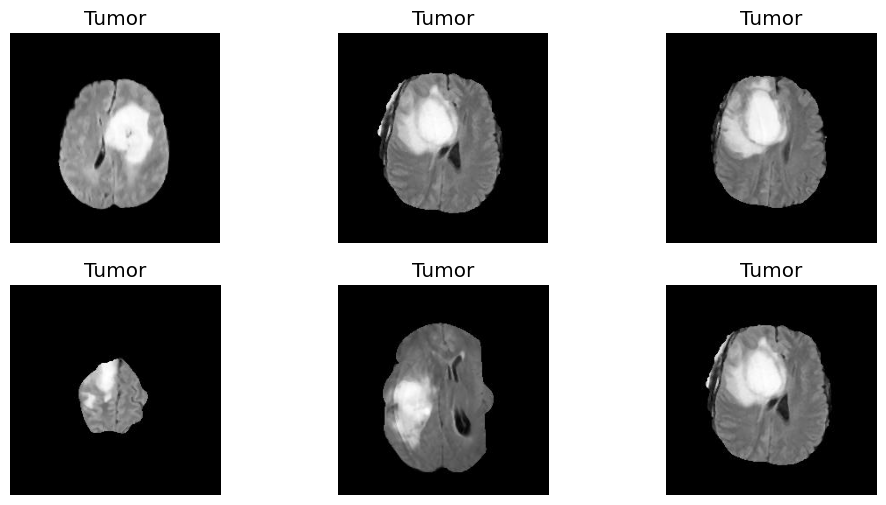

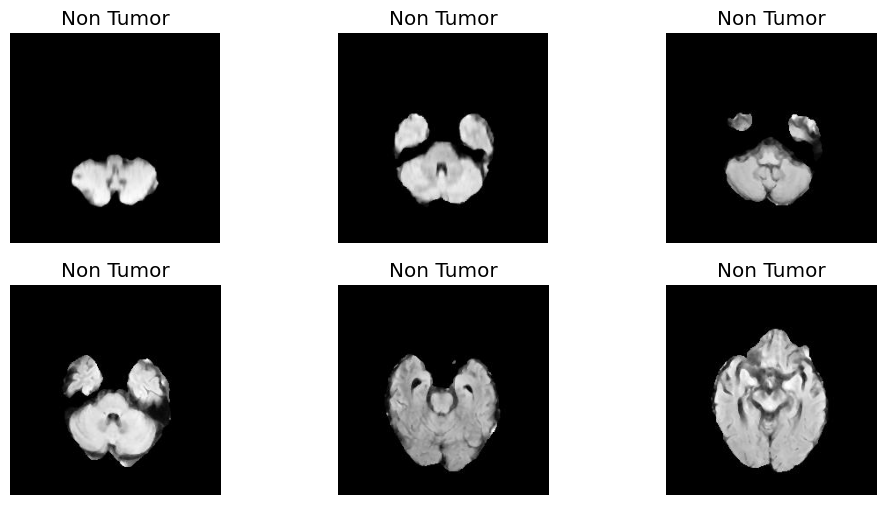

In [4]:
label_csv = pd.read_csv('data/Brain Tumor.csv')
label_csv.head()

image_folder = 'data/Brain Tumor/Brain Tumor'

# Save all the images to a folder named tumor and non_tumor
tumor_folder = 'data/labeled/tumor'
non_tumor_folder = 'data/labeled/non_tumor'

# Create the folders
os.makedirs(tumor_folder, exist_ok=True)
os.makedirs(non_tumor_folder, exist_ok=True)

# Copy the images to the folders
for index, row in label_csv.iterrows():
    image_path = os.path.join(image_folder, row['Image']+ '.jpg')
    if row['Class'] == 1:
        shutil.copy(image_path, tumor_folder)
    else:
        shutil.copy(image_path, non_tumor_folder)

# Check the number of images in each folder
print('Number of images in tumor folder:', len(os.listdir(tumor_folder)))
print('Number of images in non_tumor folder:', len(os.listdir(non_tumor_folder)))

# Display a few images from each folder
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(mpimg.imread(os.path.join(tumor_folder, os.listdir(tumor_folder)[i])))
    plt.title('Tumor')
    plt.axis('off')
plt.show()

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(mpimg.imread(os.path.join(non_tumor_folder, os.listdir(non_tumor_folder)[i])))
    plt.title('Non Tumor')
    plt.axis('off')
plt.show()


#### Load Data with tensorflow as pipline


Found 3762 files belonging to 2 classes.


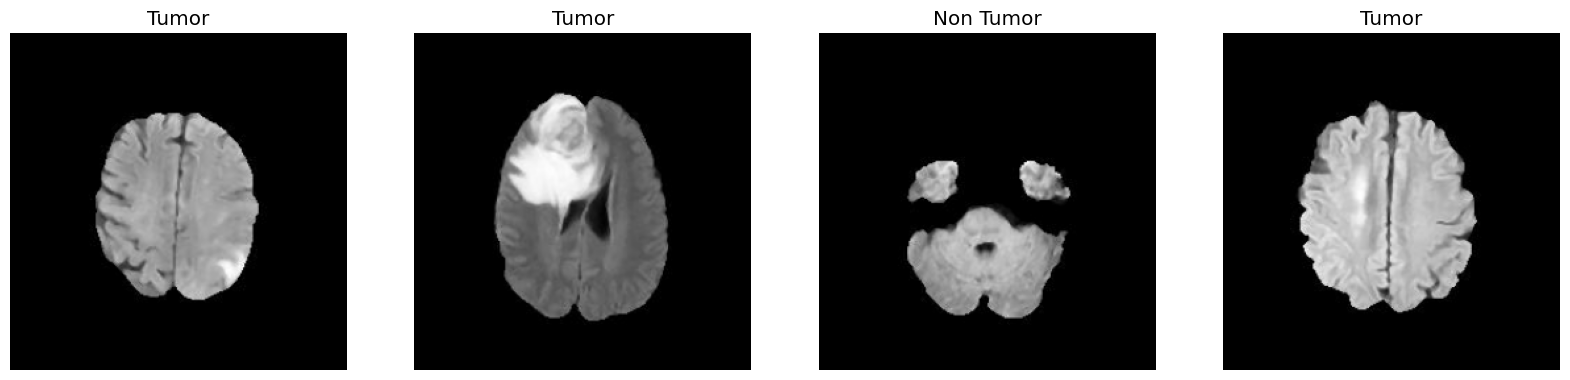

In [5]:
# building data pipeline
data = tf.keras.utils.image_dataset_from_directory('data/labeled')

# create a data iterator
data_iterator = data.as_numpy_iterator()

# creat a batch 
batch = data_iterator.next()

# images represented as numpy arrays
batch[0].shape

# plot the batch to see which class belongs to which image
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    # set the title of the image with tumor or non_tumor
    ax[idx].title.set_text('Tumor' if batch[1][idx] == 1 else 'Non Tumor')
    ax[idx].axis('off')


# Preprocessing


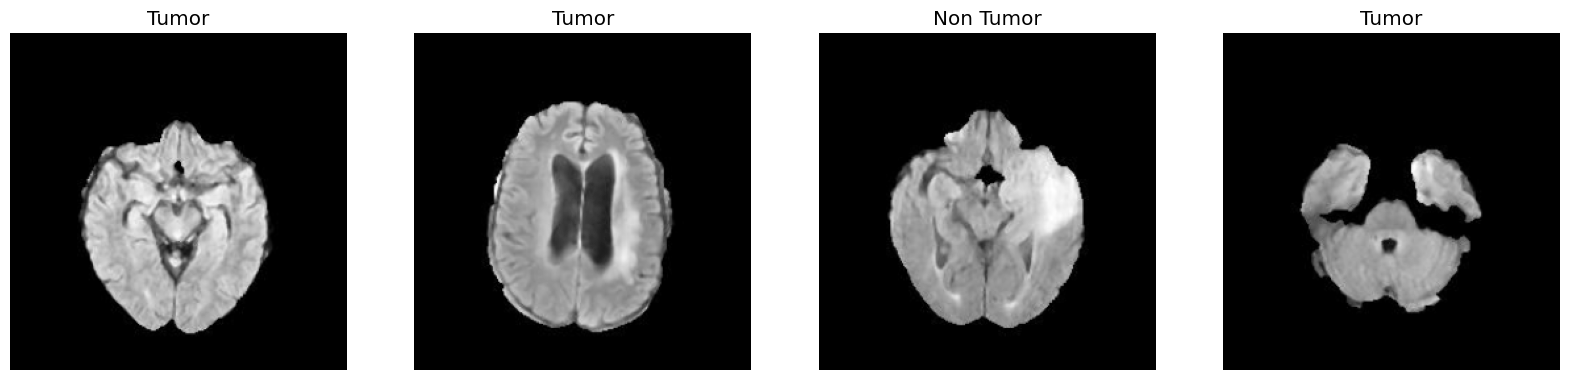

In [6]:
# scale the data pipline on the fly 
data_norm = data.map(lambda x, y: (x/255, y))

# preprocess the data to gray scale
data_gray = data.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))

# create a scaled data iterator
scaled_interator = data_gray.as_numpy_iterator()
scaled_batch = scaled_interator.next()
scaled_batch[0].min()

# display the batch
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(scaled_batch[0][:4]):
    ax[idx].imshow(img, cmap='gray')
    ax[idx].title.set_text('Tumor' if batch[1][idx] == 1 else 'Non Tumor')
    ax[idx].axis('off')

## Split Data


In [9]:
# decide the size of the train, validation and test datasets
print(len(data_gray))
train_size = int(len(data_gray)*.7)
val_size = int(len(data_gray)*.2)+1
test_size = int(len(data_gray)*.1)+1

train_size + val_size + test_size

118


118

In [10]:
# split the data into train, validation and test
train = data_gray.take(train_size)
val = data_gray.skip(train_size).take(val_size)
test = data_gray.skip(train_size+val_size).take(test_size)

print(len(train), len(val), len(test))


82 24 12


# Data Augementation


In [11]:
# Define data augmentation only for training
train_data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=None),
    tf.keras.layers.RandomBrightness(0.1, value_range=(0, 255))
])

# Apply augmentation to the training dataset
train_augmented = train.map(lambda x, y: (train_data_augmentation(x, training=True), y))

# Define the percentage of augmented data
augmented_data_percentage = 0.4

# Calculate the number of augmented images
augmented_data_size = int(len(train) * augmented_data_percentage*32)

print('Number of augmented images:', augmented_data_size)

# combine the augmented data with the original data
train_combined = train.concatenate(train_augmented.take(augmented_data_size)).shuffle(1000)

print('Number of images in the combined dataset:', len(train_combined) * 32)


Number of augmented images: 1049
Number of images in the combined dataset: 5248


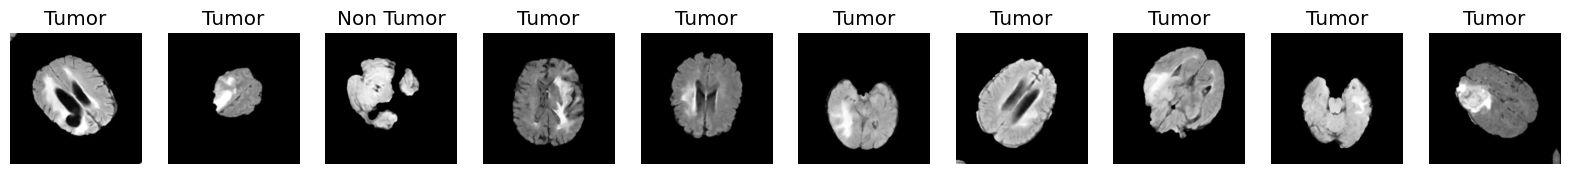

In [12]:
# display some picture of the batch
fig, ax = plt.subplots(ncols=10, figsize=(20, 20))
for idx, img in enumerate(train_combined.take(10)):
    ax[idx].imshow(img[0][0], cmap='gray')
    ax[idx].title.set_text('Tumor' if img[1][0] == 1 else 'Non Tumor')
    ax[idx].axis('off')

## Model Creation and Compilation


Epoch 1/10


c:\Users\fr3m3\anaconda3\envs\NeuNe_tensor\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


164/164 ━━━━━━━━━━━━━━━━━━━━ 76s 391ms/step - accuracy: 0.6849 - binary_accuracy: 0.6849 - loss: 27.8123 - precision: 0.6632 - recall: 0.5971 - val_accuracy: 0.7812 - val_binary_accuracy: 0.7812 - val_loss: 0.4828 - val_precision: 0.8415 - val_recall: 0.6161
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 75s 389ms/step - accuracy: 0.7905 - binary_accuracy: 0.7905 - loss: 0.4609 - precision: 0.7889 - recall: 0.7292 - val_accuracy: 0.8372 - val_binary_accuracy: 0.8372 - val_loss: 0.3964 - val_precision: 0.8852 - val_recall: 0.7177
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 75s 389ms/step - accuracy: 0.7982 - binary_accuracy: 0.7982 - loss: 0.4422 - precision: 0.8015 - recall: 0.7440 - val_accuracy: 0.8685 - val_binary_accuracy: 0.8685 - val_loss: 0.3728 - val_precision: 0.8567 - val_recall: 0.8441
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 72s 373ms/step - accuracy: 0.8474 - binary_accuracy: 0.8474 - loss: 0.3537 - precision: 0.8403 - recall: 0.8165 - val_accuracy: 0.9076 - val_binary_accuracy: 0.907

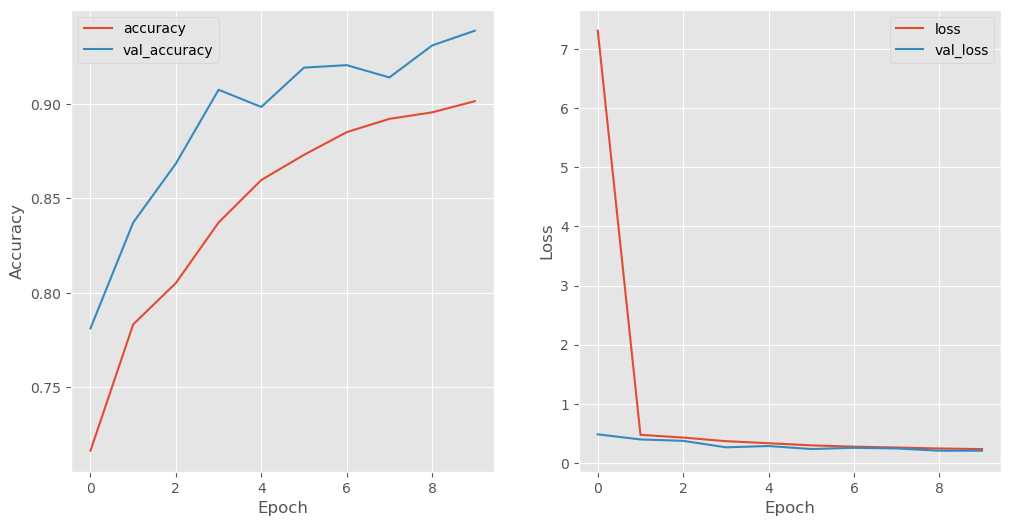

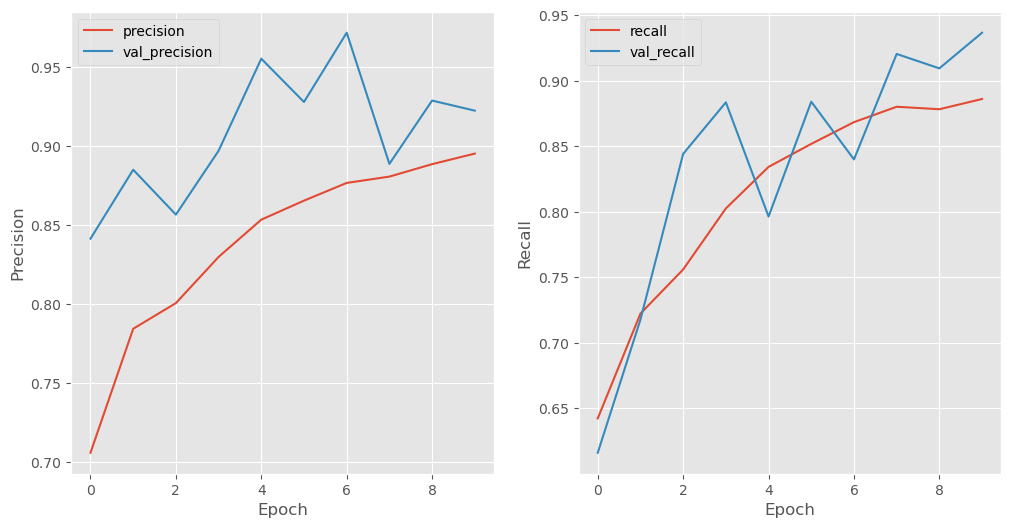

In [13]:
# Create a neural network model which loads the images and classifies them as tumor or non-tumor and the csv file with values like standard deviation, mean, etc.
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(), Recall(), BinaryAccuracy(), 'accuracy'])

# Train the model
history = model.fit(train_combined, validation_data=val, epochs=10, callbacks=[EarlyStopping(patience=3)])


# Plot the accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot the precision and recall
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Evaluate Performance


In [16]:
# Messures used for classification problems, precision, recall and accuracy. 
# Establish instance of precision, recall and accuracy
pre =  Precision()
re = Recall()
acc = BinaryAccuracy()

# Iterate over the test dataset
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

    # Reshape yhat if necessary to match the dimensions of y
    if yhat.shape[-1] == 1:
        yhat = tf.squeeze(yhat, axis=-1)  # Squeeze the last dimension

    # Update metric states
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)  # Here, we correctly use BinaryAccuracy

print('Precision:', pre.result().numpy())
print('Recall:', re.result().numpy())
print('Accuracy:', acc.result().numpy())

# Calculate the AUC
auc = roc_auc_score(y, yhat)
print('AUC:', auc)

# Calculate the F1 score
f1 = f1_score(y, yhat > 0.5)
print('F1:', f1)

# Print the results after processing all batches


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Precision: 0.85549134
Recall: 0.91358024
Accuracy: 0.8964121
AUC: 1.0
F1: 0.9411764705882353


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


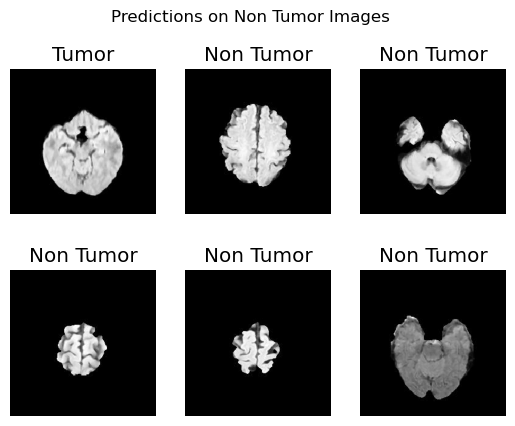

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


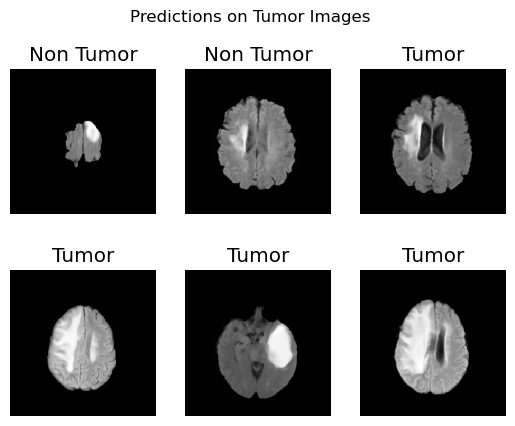

In [18]:
# Predictions on test dataset and display the images
tumor_folder = 'data/labeled/tumor'
non_tumor_folder = 'data/labeled/non_tumor'

# Make 6 predictions on the test dataset without tumor
non_tumor_folder_random_images = os.listdir(non_tumor_folder)

# select 6 random images
random.shuffle(non_tumor_folder_random_images)

for i, image in enumerate(non_tumor_folder_random_images[:6]):
    img = tf.keras.preprocessing.image.load_img(os.path.join(non_tumor_folder, image), target_size=(256, 256), color_mode='grayscale')
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    prediction = model.predict(img_array)
    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title('Non Tumor' if prediction < 0.5 else 'Tumor')
    plt.axis('off')
    plt.suptitle('Predictions on Non Tumor Images')
plt.show()

tumor_folder_random_images = os.listdir(tumor_folder)

# select 6 random images
random.shuffle(tumor_folder_random_images)

# Make 6 predictions on the test dataset with tumor
for i, image in enumerate(tumor_folder_random_images[:6]):
    img = tf.keras.preprocessing.image.load_img(os.path.join(tumor_folder, image), target_size=(256, 256), color_mode='grayscale')
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    prediction = model.predict(img_array)
    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title('Non Tumor' if prediction < 0.5 else 'Tumor')
    plt.axis('off')
    plt.suptitle('Predictions on Tumor Images')

# Save the Model


In [36]:
# Create the model folder
os.makedirs('model', exist_ok=True)

# Save the model
model.save(os.path.join('model', 'brain_tumor_classifier.keras'))

# save the model in the h5 format
model.save('model/brain_tumor_classifier.h5')

# Showcase the Model

Now you can use the model to predict the class of any brain MRI image.

Create for that a new virtual environment and install the required libraries:

```bash
pip install -r requirements.txt
```

Then you can start the streamlit app with the following command:

```bash
streamlit run dashboard.py
```

